### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [3]:
aq_datasets = firealarm_processing.get_datasets()

In [4]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

,GlobalAttrTitle,GlobalAttrSource
0,MERRA-2 Global CDH,GES DISC
1,MERRA-2 Global PBLH,GES DISC
2,MERRA-2 Global TLML,GES DISC
3,MODIS Terra AOD 550 Dark Target Deep Blue Comb...,Giovanni
4,MODIS Terra Aerosol Optical Depth Land Ocean Mean,Giovanni
24,Sentinel-5P TROPOMI Methane CH4 California,GES DISC
25,Sentinel-5P TROPOMI Carbon Monoxide CO California,GES DISC
26,Sentinel-5P TROPOMI Tropospheric NO2 California,GES DISC
27,Sentinel-5P TROPOMI Total Ozone California,GES DISC
28,Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...,GES DISC


### In-situ data inventory

In [5]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

,provider,project
0,AirNow,air_quality
1,AirNow,AQACF
2,GRIMM-Aethalometer,AQACF
3,PurpleAir,AQACF
4,QuantAQ,AQIC-Raw
5,QuantAQ,AQIC
6,QuantAQ,AQIC-Hourly
7,PurpleAir-GMU-Cal,air_quality
8,PurpleAir-GMU-Intermediate,air_quality
9,PurpleAir-GMU-Raw-Hourly,air_quality


In [6]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

,index,platform,platform_short_name,lat,lon,min_datetime,max_datetime
0,0,000010102,St. John's,47.652800,-52.816700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
1,1,000010401,Mount Pearl,47.505000,-52.794700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
2,2,000010501,Grand Falls Windsor,49.019400,-55.802800,2018-01-01T00:00:00Z,2021-03-31T00:00:00Z
3,3,000010601,Goose Bay,53.304700,-60.364400,2018-01-02T00:00:00Z,2024-03-31T00:00:00Z
4,4,000010602,MacPherson Avenue - Corner Brook,48.952240,-57.922070,2020-01-01T00:00:00Z,2022-02-28T00:00:00Z
...,...,...,...,...,...,...,...
3471,7059,TT1010003,Inchelium,48.296960,-118.202420,2018-01-09T00:00:00Z,2019-05-31T00:00:00Z
3472,7060,TT5420500,Santa Rosa Rancheria,36.233333,-119.765083,2018-01-01T00:00:00Z,2023-08-24T00:00:00Z
3473,7062,TT9209004,Miami,36.922222,-94.838890,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z
3474,7064,UB1010001,Ulaanbaatar,47.928385,106.929470,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z


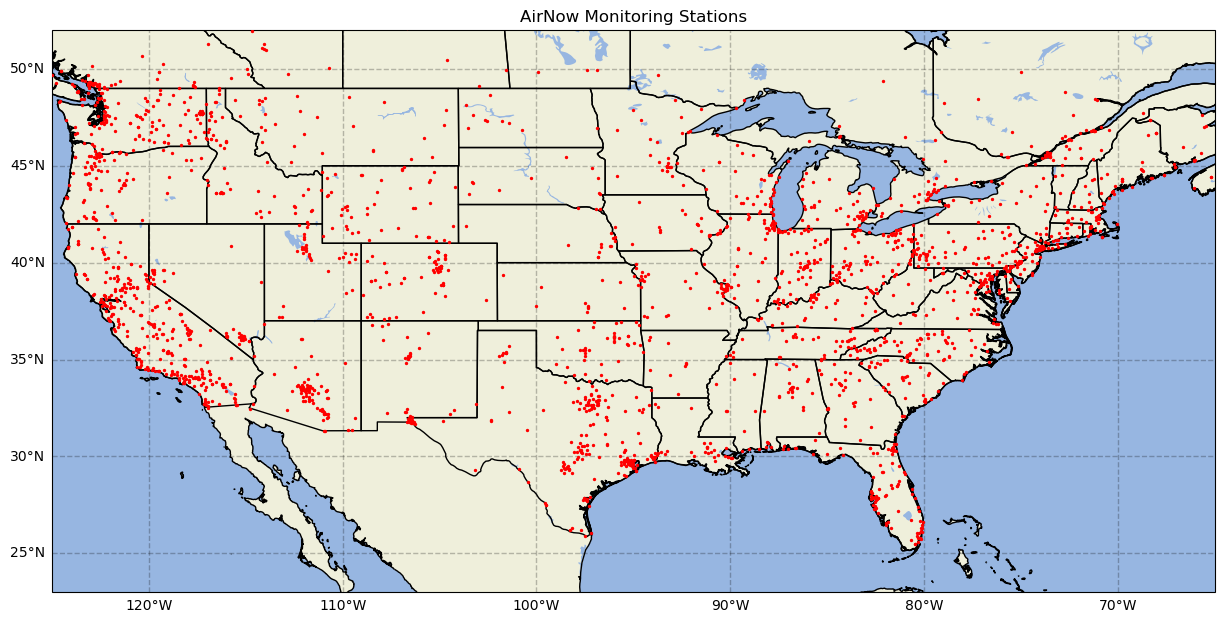

In [7]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# Fireworks during 4th of July 2022 in Los Angeles County
Despite fireworks being outlawed for personal use in Los Angeles County, there is a significant amount of illegal fireworks displays in the area around 4th of July that cause very smoggy conditions.  
Below we model our in situ Particulate matter 2.5 and Black Carbon data from around 4th of July 

Relevant Articles:
- http://www.aqmd.gov/docs/default-source/news-archive/2022/fireworks-advisory-7-2-2022.pdf
- https://www.latimes.com/california/story/2022-07-05/poor-air-quality-lingering-in-los-angeles-after-fourth-of-firework-shows 

### Area of Interest

In [8]:
la_fireworks_bb = {
    'min_lon': -118.4,
    'max_lon': -118,
    'min_lat': 33.75,
    'max_lat': 34.3
}
la_fireworks_start_time = datetime(2021,6,1)
la_fireworks_end_time = datetime(2021,7,14)

### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2021-06-28 to 2021-07-11)

In [9]:
bb_string_fireworks       = '-120,30,-115,40'
provider_fireworks        = 'GRIMM-Aethalometer'

pm25_bc_2021_fireworks = firealarm_processing.insitu(provider_fireworks, 'AQACF', 
                                                 bb_string_fireworks, datetime(2021,6,24), 
                                                 datetime(2021,7,6))

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=GRIMM-Aethalometer&project=AQACF&startTime=2021-06-24T00:00:00Z&endTime=2021-07-06T00:00:00Z&bbox=-120,30,-115,40


### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2022-06-28 to 2022-07-11)

In [10]:
pm25_bc_2022_fireworks = firealarm_processing.insitu(provider_fireworks, 'AQACF', 
                                                 bb_string_fireworks, datetime(2022,6,24),  datetime(2022,7,6))

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=GRIMM-Aethalometer&project=AQACF&startTime=2022-06-24T00:00:00Z&endTime=2022-07-06T00:00:00Z&bbox=-120,30,-115,40


In [11]:
pm25_bc_2021_fireworks_time = pm25_bc_2021_fireworks.copy(deep=True)
pm25_bc_2021_fireworks_time.time = pm25_bc_2021_fireworks_time.time + np.timedelta64(1, 'Y')

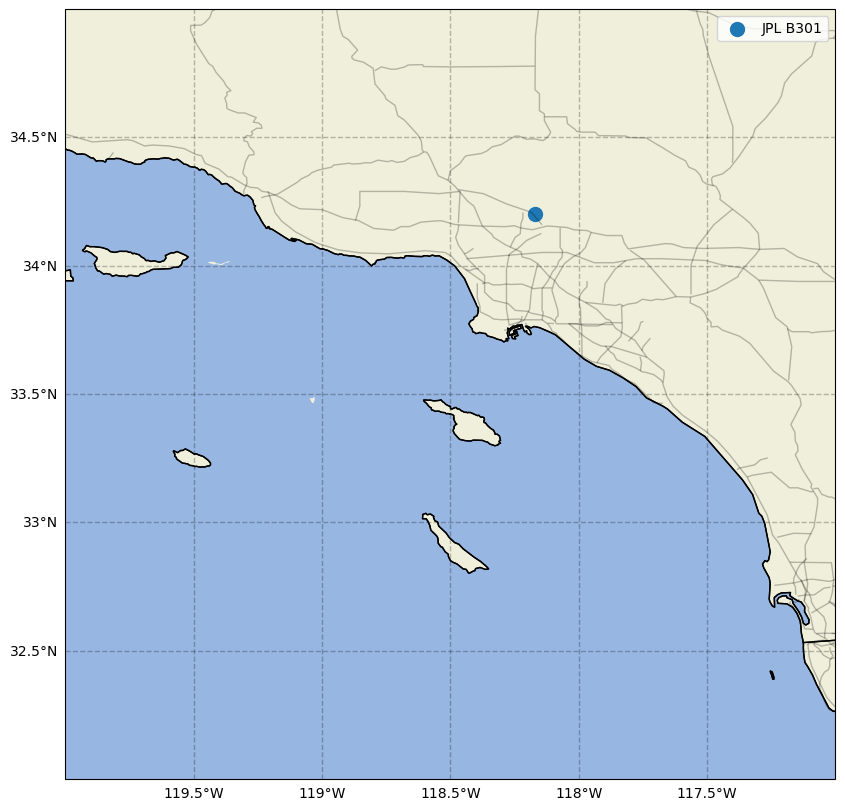

In [12]:
plotting.map_points([(pm25_bc_2021_fireworks_time.latitude.values[0], pm25_bc_2021_fireworks_time.longitude.values[0], 'JPL B301')], region='la')

## Compare 2021 and 2022 emissions 
Unlike last year, PM2.5 levels showed only a minor elevation during the night of July 4th. However, a large peak (up to 100 µg/m3) was observed during the morning of July 5th, comparable to the levels measured last year, most likely due to the transport of smoke from South/Central LA.

As expected, Black Carbon (BC) levels did not show an appreciable increase during the fireworks event. Fireworks do not emit very large amounts of BC relative to other species. Organic and inorganic aerosols (particularly metals) dominate emissions from fireworks. A PM2.5 sample was collected, using the Aerosol Mass and Optical Depth (AMOD) instrument, for chemical analysis which includes X-ray fluorescence (XRF) spectroscopy for detection of metals.

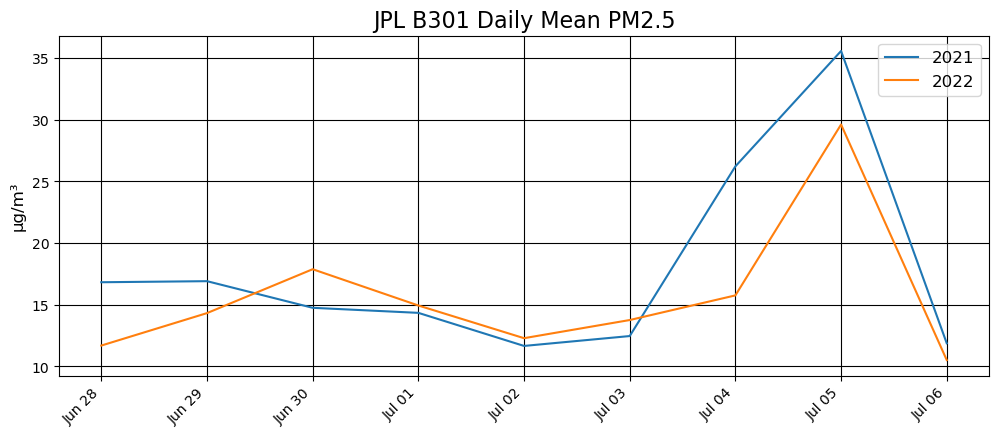

In [13]:
plotting.plot_insitu([(pm25_bc_2021_fireworks_time, 'pm2_5', '2021'), (pm25_bc_2022_fireworks, 'pm2_5', '2022')], 'JPL B301 Daily Mean PM2.5', 'µg/m³', shared_year=True)

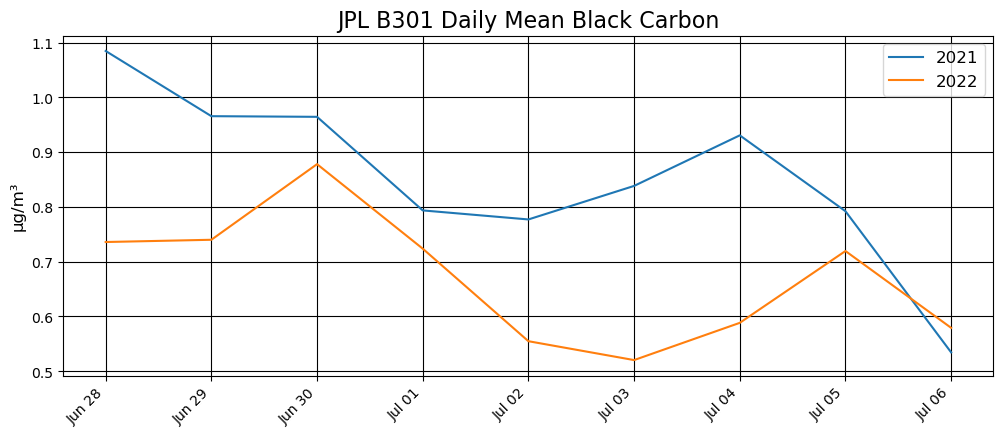

In [14]:
plotting.plot_insitu([(pm25_bc_2021_fireworks_time, 'bc', '2021'), (pm25_bc_2022_fireworks, 'bc', '2022')], 'JPL B301 Daily Mean Black Carbon', 'µg/m³', shared_year=True)

In [15]:
pm25_pm_2022_purpleair = firealarm_processing.insitu('PurpleAir', 'AQACF', 
                                                 bb_string_fireworks, datetime(2022,6,24),  datetime(2022,7,6))

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=PurpleAir&project=AQACF&startTime=2022-06-24T00:00:00Z&endTime=2022-07-06T00:00:00Z&bbox=-120,30,-115,40


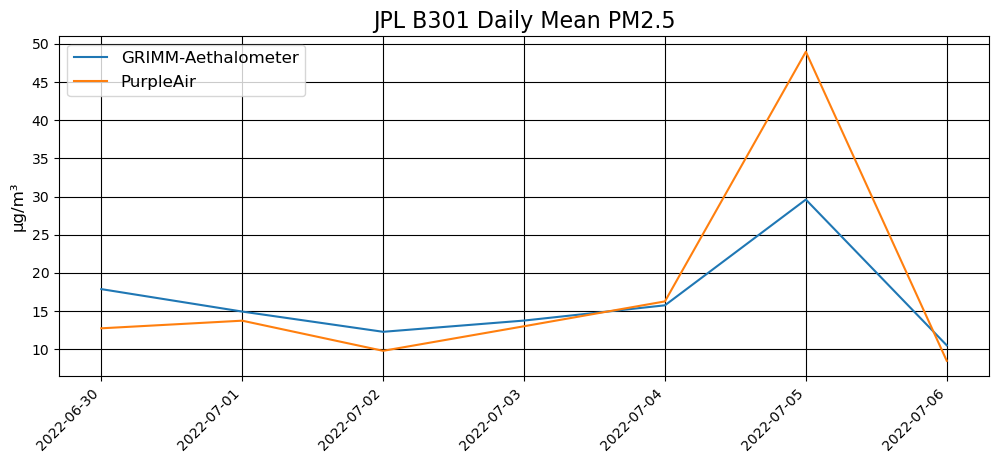

In [16]:
plotting.plot_insitu([(pm25_bc_2022_fireworks[2:], 'pm2_5', 'GRIMM-Aethalometer'), (pm25_pm_2022_purpleair, 'pm2_5', 'PurpleAir')], 'JPL B301 Daily Mean PM2.5', 'µg/m³', shared_year=False)